# WISE2MBH Tutorial

In [1]:
import wise2mbh as wm
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import random
no_data = 9876543

In [2]:
allwise = Table.read('../samples/AllWISE_sample.fits')
allwise

ONAME,RA,DEC,Z,T,NED_TYPE,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist
bytes107,float64,float64,float64,float64,bytes7,bytes19,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes4,bytes1,bytes4,bytes4,int32,int32,int32,int32,float32,float64
WISEAJ112428.14-363548.5,171.1172539,-36.5968225,0.2,9876543.0,Unknown,J112428.14-363548.5,171.1172539,-36.5968225,0.0427,0.0415,130.3,13.449,12.486,9.394,6.977,15.185,14.474,14.293,0.025,0.024,0.033,0.084,0.056,0.061,0.075,1716036401351015875,0000,0,1122,AAAA,160,54,42,55,2.073,1e-06
WISEAJ144229.68-435343.2,220.6236974,-43.8953408,0.3,9876543.0,Unknown,J144229.68-435343.2,220.6236974,-43.8953408,0.1285,0.1177,11.9,15.975,14.663,10.911,7.801,--,--,--,0.055,0.06,0.118,0.195,--,--,--,2205044001351034712,0000,0,011n,AABB,412,466,-34,505,--,1e-06
WISEAJ163728.75+290335.9,249.3698107,29.0599733,0.2,9876543.0,Unknown,J163728.75+290335.9,249.3698107,29.0599733,0.0692,0.0643,4.9,15.637,13.775,9.703,7.347,--,--,--,0.04,0.034,0.038,0.124,--,--,--,2485128701351042160,0000,0,0011,AAAB,-116,295,-250,278,--,2e-06
WISEAJ184321.55-621724.8,280.8398056,-62.2902233,0.2,9876543.0,Unknown,J184321.55-621724.8,280.8398056,-62.2902233,0.0722,0.0689,38.8,14.624,13.762,11.04,8.519,--,--,--,0.036,0.035,0.106,--,--,--,--,2810062101351018362,0000,0,nnnn,AAAU,--,--,--,--,--,5e-06
WISEAJ183203.33+633041.5,278.0139066,63.5115391,0.3,9876543.0,Unknown,J183203.33+633041.5,278.0139066,63.5115391,0.0662,0.0627,129.3,15.811,14.794,11.508,8.357,--,--,--,0.032,0.035,0.086,0.118,--,--,--,2774163601351028837,0000,0,11nn,AAAB,155,233,-229,248,--,7e-06
WISEAJ000517.26-341452.8,1.321926,-34.2480098,0.3,9876543.0,Unknown,J000517.26-341452.8,1.321926,-34.2480098,0.0752,0.0713,141.6,15.1,14.143,10.839,7.887,--,--,--,0.035,0.04,0.114,0.189,--,--,--,18034901351061482,0000,0,110n,AABB,289,256,-282,261,--,7e-06
WISEAJ041514.13-810745.9,63.8088863,-81.1294387,0.2,9876543.0,Unknown,J041514.13-810745.9,63.8088863,-81.1294387,0.0457,0.0449,162.3,14.499,13.543,10.429,7.558,--,--,--,0.025,0.026,0.048,0.099,--,--,--,681081801351062155,0000,0,110n,AAAA,260,66,92,69,--,8e-06
WISEAJ150206.92+781622.6,225.5288639,78.2729584,0.3,9876543.0,Unknown,J150206.92+781622.6,225.5288639,78.2729584,0.0886,0.0831,95.1,15.959,15.085,12.15,9.497,--,--,--,0.037,0.05,0.202,0.512,--,--,--,2232178701351000385,0000,0,11nn,AABC,-761,305,100,285,--,9e-06
WISEAJ050357.41-282633.0,75.989223,-28.4425115,0.2,9876543.0,Unknown,J050357.41-282633.0,75.989223,-28.4425115,0.1182,0.0847,153.4,15.102,14.292,11.284,8.529,--,--,--,0.045,0.045,0.125,0.332,--,--,--,754028801351050034,0000,0,nnnn,AABB,--,--,--,--,--,1.1e-05


Clening process of the sample from AllWISE

In [3]:
size_before_depure = len(allwise)
print(f'Size before depure: {size_before_depure}')

allowed_z = allwise[allwise['Z']!=0]                                                            #Masking of null redshifts
qph_list = allwise['qph'].tolist()                                                              #Extract quality flags
null_phot = ['X', 'Z']                                                                          #Null and uplim values in W bands
not_null_quality = [not any(letter in qph[:-1] for letter in null_phot) for qph in qph_list]    #Test quality flags

allwise = allowed_z[not_null_quality].copy()                                                    #Keep non-null values in quality

size_after_depure = len(allwise)
print(f'Size after depure: {size_after_depure}')

Size before depure: 77712
Size after depure: 77687


Detections with 'U' flag in qph do not contain errors on the WISE bands, so better to set them to a single value, in this case we'll set them to 0

In [4]:
allwise['e_W1mag'] = allwise['e_W1mag'].filled(0)                 #Replace null errors in WISE bands
allwise['e_W2mag'] = allwise['e_W2mag'].filled(0)
allwise['e_W3mag'] = allwise['e_W3mag'].filled(0)

Since this algorithm have a Monte Carlo implementation for error propagation, we recommend to take slices for big sample (rows>200), so for this tutorial, we'll use a random slice from the AllWISE sample.

In [5]:
random_indices = random.sample(range(len(allwise)), 1000)
new_allwise = allwise[random_indices]
new_allwise

ONAME,RA,DEC,Z,T,NED_TYPE,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M,angDist
bytes107,float64,float64,float64,float64,bytes7,bytes19,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes4,bytes1,bytes4,bytes4,int32,int32,int32,int32,float32,float64
SDSS519127575151273984,51.53498,-7.0967,0.14470774,9876543.0,Galaxy,J032608.39-070548.0,51.534974,-7.0966926,0.0539,0.0532,143.3,13.955,13.793,12.48,9.134,15.615,15.108,14.592,0.026,0.035,0.487,--,0.076,0.099,0.115,518007601351060454,0000,0,11nn,AACU,-80,64,-75,67,0.155,0.034179
WISEAJ131653.76+252128.1,199.2240215132,25.3578253217,0.298592,9876543.0,Unknown,J131653.76+252128.1,199.2240274,25.35783,0.0627,0.0606,161.8,14.416,14.16,12.196,8.518,16.484,15.724,15.097,0.027,0.042,0.0,--,0.121,0.134,0.115,2000125701351013563,0000,0,00nn,AAUU,-96,129,229,139,0.156,0.025463
SDSS827543345738835968,333.33448,12.09324,0.19418554,9876543.0,Galaxy,J221320.27+120535.6,333.3344767,12.0932442,0.0659,0.0635,126.5,14.453,14.189,12.373,8.987,16.021,15.426,14.819,0.028,0.045,0.0,--,0.095,0.13,0.114,3337112101351032412,0000,0,11nn,AAUU,283,161,-185,166,0.177,0.019033
PGC103374,66.577875,-42.3295556,0.12505667,9876543.0,Unknown,J042618.69-421946.3,66.577875,-42.3295521,0.0474,0.0465,106.4,13.992,13.402,10.476,9.322,16.143,15.424,14.838,0.026,0.027,0.059,0.534,0.111,0.108,0.126,667042501351030920,0000,0,331n,AAAC,16,192,146,138,0.16,0.01255
[RGD2016]J235043.82+293938.6,357.6825705,29.6607133,0.23076,9876543.0,Unknown,J235043.81+293938.6,357.6825672,29.6607233,0.0665,0.0633,124.2,14.416,14.035,11.911,8.699,16.098,15.597,14.817,0.029,0.043,0.0,--,0.089,0.137,0.126,3582130201351009353,0000,0,00nn,AAUU,-106,158,-88,158,0.211,0.037517
SDSS2569324539926308864,135.199,21.36836,0.1936367,9876543.0,Galaxy,J090047.76+212206.0,135.199013,21.3683597,0.0565,0.0548,136.7,13.905,13.556,11.774,8.74,15.927,15.181,14.411,0.026,0.036,0.0,--,0.079,0.095,0.068,1356121201351038582,0000,0,00nn,AAUU,130,110,-102,116,0.114,0.04358
SDSSJ144857.47+380757.3,222.239472,38.1325867,0.32208934,9876543.0,Unknown,J144857.47+380757.2,222.2394711,38.1325825,0.0681,0.065,170.2,14.982,14.791,12.858,8.935,--,--,--,0.028,0.05,0.467,--,--,--,--,2216137801351048665,0000,0,00nn,AACU,-109,104,124,112,--,0.015395
SDSSJ085308.62-002918.6,133.2859215,-0.4885192,0.33192,9876543.0,Unknown,J085308.62-002918.6,133.2859294,-0.4885156,0.0881,0.0829,2.6,15.0,14.826,12.057,8.851,17.051,16.281,15.509,0.035,0.063,0.0,--,0.191,0.227,0.226,1331100001351002731,0000,0,00nn,AAUU,151,223,-231,247,0.549,0.031366
GAMA347437,137.74268700000002,2.1658913,0.26038966,9876543.0,Unknown,J091058.24+020957.2,137.7426819,2.1658957,0.0871,0.0808,180.0,14.916,14.506,12.033,8.406,16.683,16.164,14.969,0.035,0.058,0.0,--,0.171,0.173,0.148,1376101501351056108,0000,0,00nn,AAUU,-81,221,490,243,0.222,0.024346


First, store the observed colors and then define the Monte Carlo arrays for W1, W2 and W3, with the same colors but now for Monte Carlo arrays

In [6]:
new_allwise['W1-W2_obs'] = new_allwise['W1mag'] - new_allwise['W2mag']
new_allwise['W2-W3_obs'] = new_allwise['W2mag'] - new_allwise['W3mag']

In [7]:
w1 = wm.array_montecarlo(new_allwise['W1mag'],new_allwise['e_W1mag'])
w2 = wm.array_montecarlo(new_allwise['W2mag'],new_allwise['e_W2mag'])
w3 = wm.array_montecarlo(new_allwise['W3mag'],new_allwise['e_W3mag'])
z = np.array(new_allwise['Z'])

w1w2_obs = w1-w2
w2w3_obs = w2-w3

# K-corrections for the defined sample

Now that all initial colors are created, one can start by the first masking of the reject zone by deleting all sources with a W2-W3>4.4

In [8]:
first_reject_zone = new_allwise['W2-W3_obs']<=4.4

In [9]:
w1 = w1[first_reject_zone]
w2 = w2[first_reject_zone]
w3 = w3[first_reject_zone]
z = z[first_reject_zone]

w1w2_obs = w1w2_obs[first_reject_zone]
w2w3_obs = w2w3_obs[first_reject_zone]

new_allwise = new_allwise[first_reject_zone]

It is necessary to create new arrays to store K-corrected W1abs and the K-correction factor of W1-W2 and W2-W3

In [10]:
w1w2_kcors = np.zeros(np.shape(w1w2_obs)[0])                                                
w2w3_kcors = np.zeros(np.shape(w2w3_obs)[0])
w1abs = np.zeros(np.shape(w1))

In [11]:
object_condition = (new_allwise['NED_TYPE']=='RadioS') | (new_allwise['NED_TYPE']=='QSO')
color_condition_1 = (new_allwise['W1-W2_obs']>0.8) & (new_allwise['W2-W3_obs']<2.2)
color_condition_2 = (new_allwise['W1-W2_obs']>wm.w1w2_treshold_qso(new_allwise['W2-W3_obs'])) & (new_allwise['W2-W3_obs']>=2.2) & (new_allwise['W2-W3_obs']<=4.4)

suboptimal_cond = (new_allwise['Z']>=0.5) & (new_allwise['Z']<=3) & ~object_condition & ~(color_condition_1 | color_condition_2)
nok_cond = (new_allwise['Z']>3) | object_condition | color_condition_1 | color_condition_2

optimal_sample = new_allwise[(new_allwise['Z']<0.5) & ~object_condition & ~(color_condition_1 | color_condition_2)]
suboptimal_sample = new_allwise[suboptimal_cond]                                                                            #Samples for k-correcion                
nok_sample = new_allwise[nok_cond]

To create the final quality tag, here we store the K-correction tag

In [12]:
new_allwise['K_QUALITY'] = int(0)

new_allwise['K_QUALITY'] = np.where(suboptimal_cond, int(1), new_allwise['K_QUALITY'])
new_allwise['K_QUALITY'] = np.where(nok_cond, int(2), new_allwise['K_QUALITY'])

Now we import the look-up tables from Jarrett+2023 to use

In [13]:
e_table = wm.kcorr_table('E')
l_table = wm.kcorr_table('L')
s_table = wm.kcorr_table('S')

In [14]:
e_table

,z,f1,W1-W2,W1-W3,W3-W4,W2-W3
0,0.00050,1.000,-0.000,-0.000,-0.000,-0.000
1,0.00100,1.000,0.000,0.001,0.000,0.001
2,0.00150,0.998,0.002,0.001,0.001,-0.001
3,0.00200,0.995,0.000,0.000,0.001,0.000
4,0.00250,0.995,0.005,0.002,0.002,-0.003
...,...,...,...,...,...,...
827,2.87603,0.043,0.930,1.733,-0.180,0.803
828,2.90479,0.043,0.941,1.758,-0.180,0.817
829,2.93384,0.043,0.952,1.783,-0.181,0.831
830,2.96318,0.043,0.963,1.808,-0.182,0.845


In [15]:
identifier = np.random.choice(np.arange(10), size=3, replace=False)
for idn, sample in zip(identifier,[optimal_sample, suboptimal_sample, nok_sample]):
    if len(sample)!=0:
        if idn!=identifier[2]:                                                                      #Color k-correction for sample with z<0.5
            object_condition = (sample['NED_TYPE']=='RadioS') | (sample['NED_TYPE']=='QSO')

            e_index = np.where((sample['T']<=-3) & ~object_condition)[0]
            l_index = np.where((sample['T']>-3) & (sample['T']<=0) & ~object_condition)[0]          #Divide samples in Elliptical, Lenticular and Spiral by T value
            s_index = np.where((sample['T']>0) & (sample['T']!=no_data) & ~object_condition)[0]

            no_type_index = np.where((sample['T']==no_data) & ~object_condition)[0]                 #Sample without T values
            w1w2_no_type = sample[no_type_index]['W1-W2_obs']                                      
            w2w3_no_type = sample[no_type_index]['W2-W3_obs']  
            z_no_type = sample[no_type_index]['Z']                                                    

            e_w1_kcorrected = wm.w1_k_corrected(lookup_table=e_table,w1=w1[e_index],z=z[e_index])
            l_w1_kcorrected = wm.w1_k_corrected(lookup_table=l_table,w1=w1[l_index],z=z[l_index])   #W1 k-corrected 
            s_w1_kcorrected = wm.w1_k_corrected(lookup_table=s_table,w1=w1[s_index],z=z[s_index])

            e_w2w3_kcor = wm.get_correction_factor(lookup_table=e_table, redshift=sample[e_index]['Z'], correction_factor='W2-W3')
            l_w2w3_kcor = wm.get_correction_factor(lookup_table=l_table, redshift=sample[l_index]['Z'], correction_factor='W2-W3')     #W2-W3 k-correction factor
            s_w2w3_kcor = wm.get_correction_factor(lookup_table=s_table, redshift=sample[s_index]['Z'], correction_factor='W2-W3')

            e_w1w2_kcor = wm.get_correction_factor(lookup_table=e_table, redshift=sample[e_index]['Z'], correction_factor='W1-W2')
            l_w1w2_kcor = wm.get_correction_factor(lookup_table=l_table, redshift=sample[l_index]['Z'], correction_factor='W1-W2')     #W1-W2 k-correction factor
            s_w1w2_kcor = wm.get_correction_factor(lookup_table=s_table, redshift=sample[s_index]['Z'], correction_factor='W1-W2')

            #Both k-correction factors for no type sample, using division by observed W2-W3 color
            factor_w2 = 171.787
            factor_w3 = 31.674

            w2w3_limit = -2.5*(np.log10(factor_w3/factor_w2) + 0.1)                             #Last value is the flux limit from Mateos et al. (2012)

            no_type_w1w2_kcor = [
                wm.get_correction_factor(lookup_table=e_table, redshift=z, correction_factor='W1-W2') if (color_x<=w2w3_limit)
                else wm.get_correction_factor(lookup_table=s_table, redshift=z, correction_factor='W1-W2') if (color_x>w2w3_limit) else 0
                for color_x,color_y,z in zip(w2w3_no_type,w1w2_no_type, z_no_type)
                ]
            no_type_w2w3_kcor = [
                wm.get_correction_factor(lookup_table=e_table, redshift=z, correction_factor='W2-W3') if (color_x<=w2w3_limit)
                else wm.get_correction_factor(lookup_table=s_table, redshift=z, correction_factor='W2-W3') if (color_x>w2w3_limit)  else 0
                for color_x,color_y,z in zip(w2w3_no_type,w1w2_no_type, z_no_type)
                ]

            no_type_w1_kcorrected = [
                wm.w1_k_corrected(lookup_table=e_table,w1=w1[no_type_id],z=np.array([z]))[0] if (color_x<=w2w3_limit)
                else wm.w1_k_corrected(lookup_table=s_table,w1=w1[no_type_id],z=np.array([z]))[0] if (color_x>w2w3_limit) else w1[no_type_index]
                for color_x,color_y,z,no_type_id in zip(w2w3_no_type,w1w2_no_type, z_no_type, no_type_index)
                ]   

            e_w1abs_kcorrected = e_w1_kcorrected - wm.distance_modulus_z(sample[e_index]['Z'])[:,None]          #W1 k-correction for e_sources
            l_w1abs_kcorrected = l_w1_kcorrected - wm.distance_modulus_z(sample[l_index]['Z'])[:,None]          #W1 k-correction for l_sources
            s_w1abs_kcorrected = s_w1_kcorrected - wm.distance_modulus_z(sample[s_index]['Z'])[:,None]          #W1 k-correction for s_sources
            no_type_w1abs_kcorrected = no_type_w1_kcorrected - wm.distance_modulus_z(z_no_type)[:,None]   #W1 k-correction for no_type_sources

            if np.shape(no_type_w1abs_kcorrected)==(0,0):
                no_type_w1abs_kcorrected = no_type_w1abs_kcorrected.reshape(0,1000)

            w1w2_kcors[e_index] = e_w1w2_kcor
            w1w2_kcors[l_index] = l_w1w2_kcor                   #W1-W2 k-correctrion factors filled
            w1w2_kcors[s_index] = s_w1w2_kcor
            w1w2_kcors[no_type_index] = no_type_w1w2_kcor

            w2w3_kcors[e_index] = e_w2w3_kcor
            w2w3_kcors[l_index] = l_w2w3_kcor                   #W2-W3 k-correctrion factors filled
            w2w3_kcors[s_index] = s_w2w3_kcor
            w2w3_kcors[no_type_index] = no_type_w2w3_kcor

            w1abs[e_index] = e_w1abs_kcorrected
            w1abs[l_index] = l_w1abs_kcorrected                 #W1abs k-corrected filled
            w1abs[s_index] = s_w1abs_kcorrected
            w1abs[no_type_index] = no_type_w1abs_kcorrected
            
        else:
            w1abs_kcorrected = w1[np.where(nok_cond)[0]] - wm.distance_modulus_z(z[np.where(nok_cond)[0]])[:,None]
            w1abs[np.where(nok_cond)[0]] = w1abs_kcorrected

            w1w2_kcors[np.where(nok_cond)[0]] = 0
            w2w3_kcors[np.where(nok_cond)[0]] = 0                                        #For sources with z>3, no k-correction is applied
    else:
        continue

In [16]:
w1w2_kcorrected = w1w2_obs - w1w2_kcors[:,None]                                 #Colors for complete slice are applied
w2w3_kcorrected = w2w3_obs - w2w3_kcors[:,None]

new_allwise['W1-W2_kcor'] = np.median(w1w2_kcorrected, axis=1)                  #Median value is saved in data frame
new_allwise['W2-W3_kcor'] = np.median(w2w3_kcorrected, axis=1)

w1w2_sat_top = wm.clipping_dist(w1w2_kcorrected, 0.6)                           #W1-W2 is saturated between -0.2 and 0.6 for M/L ratios
w1w2_sat_complete = wm.clipping_dist(w1w2_sat_top, -0.2, greater_than=False)

# Use scaling relations and wm.param_montecarlo()

Now that all necesary quantities for Stellar mass estimation are ready, one can decide if to use a simple definition (like the one provided in the package) or use the built-in function to vary the parameters. 

For this, we used the function from Cluver+2014, which is defined as follows:

In [17]:
def wise_to_logsm(w1abs, w1w2, resolved=False):
    w1_abs_sun = 3.26                   #from Willmer (2018) https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf

    log_sm_lw1 = -1.96*w1w2 - 0.03
    if resolved:
        log_sm_lw1 = -2.54*w1w2 - 0.17
    log_lw1 = -0.4*(w1abs-w1_abs_sun)   #from Cluver et al. (2014) https://iopscience.iop.org/article/10.1088/0004-637X/782/2/90
    log_sm = log_sm_lw1 + log_lw1
    
    return log_sm

This same exact function is part of WISE2MBH package and here is the intended behavior of it:

In [18]:
log_sm = wm.wise_to_logsm(w1abs, w1w2_sat_complete)

11.6192340713158 11.71210264183948 11.809822453999802


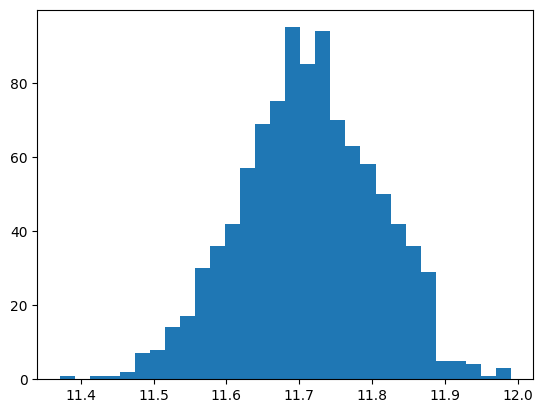

In [23]:
plt.hist(log_sm[0],bins=30)

nominal = np.median(log_sm[0])
sigma_down = np.percentile(log_sm[0],16)
sigma_top = np.percentile(log_sm[0],84)

print(sigma_down, nominal, sigma_top)

But with the use of wm.param_montecarlo() function you can include uncertainties for all parameters, like in this example:

In [36]:
def wise_to_logsm(w1abs, w1w2, resolved=False):
    w1_abs_sun = 3.26                   #from Willmer (2018) https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf

    log_sm_lw1 = wm.param_montecarlo(-1.96,0.8)*w1w2 - wm.param_montecarlo(0.03,0.03) #Fake uncertainties applied
    if resolved:
        log_sm_lw1 = -2.54*w1w2 - 0.17
    log_lw1 = -0.4*(w1abs-w1_abs_sun)   #from Cluver et al. (2014) https://iopscience.iop.org/article/10.1088/0004-637X/782/2/90
    log_sm = log_sm_lw1 + log_lw1
    
    return log_sm

In [37]:
log_sm_uncertain = wise_to_logsm(w1abs, w1w2_sat_complete)

11.551525068873588 11.728356555589016 11.876777995525902


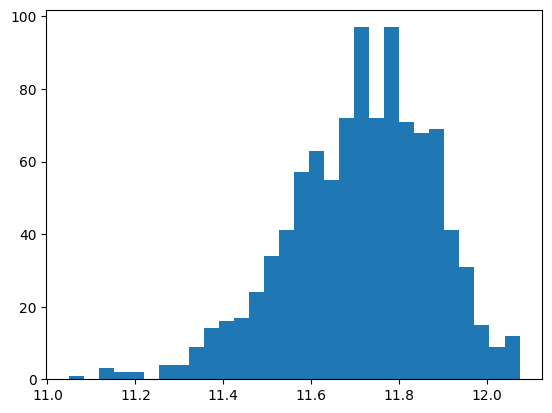

In [38]:
plt.hist(log_sm_uncertain[0],bins=30)

nominal = np.median(log_sm_uncertain[0])
sigma_down = np.percentile(log_sm_uncertain[0],16)
sigma_top = np.percentile(log_sm_uncertain[0],84)

print(sigma_down, nominal, sigma_top)

For every single scaling relation used in this work, one can easily modify the original version to include uncertainties in all parameters by the use of wm.param_montecarlo()